# import

In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import datetime
from torchvision.models import mobilenetv2
# 自作モデルのインポート
import models.ore_no_zenketugou_model as zenketu
import models.train_loop as train_loop #訓練ループを格納
import class_name # ラベルの呼び出し

# データの準備

In [2]:
# cifar100を利用する
data_path = './cifar-100'
# 訓練データと検証データのダウンロード
tensor_cifar100_train = datasets.CIFAR100(data_path,
                                          train=True,
                                          download=True,
                                          transform=transforms.ToTensor())
tensor_cifar100_val = datasets.CIFAR100(data_path,
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

# ラベルを取得
class_names = class_name.class_names()
super_class_names = class_name.super_class_names()

# テンソルを束ねる
imgs = torch.stack([img_t for img_t, _ in tensor_cifar100_train], dim = 3)

# RGB各々の平均、標準偏差を計算する
means = imgs.view(3,-1).mean(dim=1)
stds = imgs.view(3,-1).std(dim=1)

# 各画像データを標準化する
transformed_tensor_cifar100_train = datasets.CIFAR100(data_path,
                                                      train=True,
                                                      download=False,
                                                      transform=transforms.Compose([
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(means,stds),
                                                          transforms.RandomResizedCrop(size=32, scale=(0.8,1.0)), #データの拡大縮小及びアスペクト比の変更
                                                          transforms.RandomHorizontalFlip(p=0.3), # 画像をp％の確率で左右反転させる
                                                          transforms.RandomVerticalFlip(p=0.3), # 画像をp％の確率で上下反転させる
                                                          transforms.RandomRotation(degrees=(-89,89)), #-89~89度の間で回転させる
                                                          # transforms.RandomPerspective(distortion_scale=0.2,p=0.3) #画像を確率pで射影変換する
                                                      ]))
transformed_tensor_cifar100_val = datasets.CIFAR100(data_path,
                                                   train=False,
                                                   download=False,
                                                   transform = transforms.Compose([
                                                       transforms.ToTensor(),
                                                       transforms.Normalize(means,stds)
                                                   ]))

# モデル選択

In [18]:
# モデルのインスタンスの作成
model = zenketu.CNNBatchNorm_ReLU(n_chans1=256)
# パラメータの数を確認
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list)

42457060

In [19]:
# パラメータの設定
# データローダーに入れることで、簡単にデータを取り扱う
batch_size = 100
train_loader = torch.utils.data.DataLoader(
    transformed_tensor_cifar100_train,
    batch_size=batch_size,
    shuffle=False)
val_loader = torch.utils.data.DataLoader(
    transformed_tensor_cifar100_val,
    batch_size=batch_size,
    shuffle=False)
# 学習率の設定
learning_rate = 1e-2
# パラメータの修正に確率的勾配降下方を利用
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
# 損失関数を定義
loss_fn = nn.CrossEntropyLoss()
# エポック数を設定
n_epochs = 100

In [20]:
# cnn256, batch, syaeiNone
model

CNNBatchNorm_ReLU(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=100, bias=True)
)

In [21]:
# モデルの訓練
model,loss_train_lists, loss_val_lists,train_accuracies,val_accuracies = train_loop.train_loop(n_epochs = n_epochs,
                                            optimizer=optimizer,
                                            model = model,
                                            loss_fn = loss_fn,
                                            train = train_loader,
                                            val = val_loader,
                                            )

2023-02-02 14:50:35.502134Epoch:1,Traing_loss:4.430110816955566,val_loss4.205941958427429
2023-02-02 14:53:28.672904Epoch:2,Traing_loss:4.096931332588196,val_loss3.9477486658096312
2023-02-02 14:56:31.140978Epoch:3,Traing_loss:3.8995398349761965,val_loss3.7598429417610166
2023-02-02 15:16:04.199628Epoch:10,Traing_loss:3.176781466007233,val_loss3.055194790363312
2023-02-02 15:44:04.401578Epoch:20,Traing_loss:2.773423643112183,val_loss2.7207948684692385
2023-02-02 16:11:26.803569Epoch:30,Traing_loss:2.528997803211212,val_loss2.5495808577537535
2023-02-02 16:38:44.468560Epoch:40,Traing_loss:2.2877690608501435,val_loss2.442856785058975
2023-02-02 17:02:04.265915Epoch:50,Traing_loss:2.0872636358737946,val_loss2.3581822526454927
2023-02-02 17:23:16.841488Epoch:60,Traing_loss:1.8956038415431977,val_loss2.3717823994159697
2023-02-02 17:42:59.295035Epoch:70,Traing_loss:1.7017528643608093,val_loss2.372045978307724
2023-02-02 18:03:12.048834Epoch:80,Traing_loss:1.4953101115226746,val_loss2.451435

# 結果表示

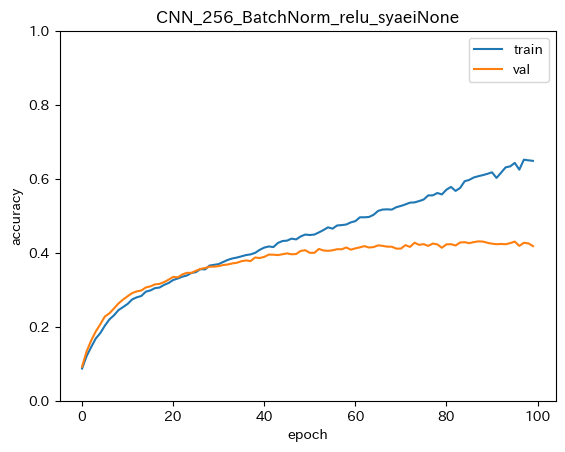

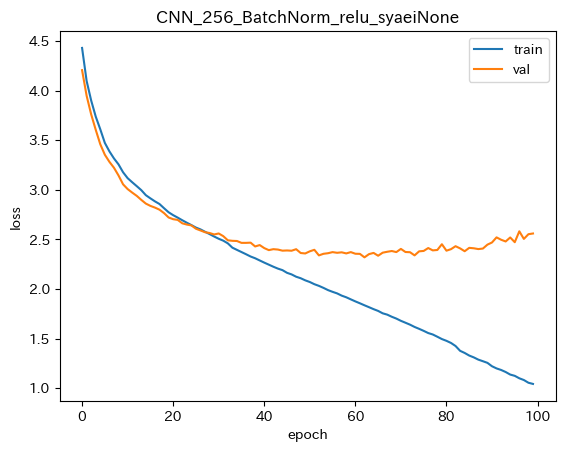

In [22]:
title = 'CNN_256_BatchNorm_relu_syaeiNone'
plt.plot(train_accuracies,label = 'train')
plt.plot(val_accuracies, label ='val')
plt.title(f'{title}')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend()
plt.savefig(f'picture/accuracy_{title}')
plt.show()
# 損失
plt.plot(loss_train_lists,label = 'train')
plt.plot(loss_val_lists, label ='val')
plt.title(f'{title}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(f'picture/{title}.png')
plt.show()

In [12]:
# モデルのパラメータの保存保存
d_path = './para_models/'
torch.save(model.state_dict(), d_path + f'{title}.pt')

In [ ]:
# モデルの呼び出し
# loaded_model = zenketu.Zenketugou()
# loaded_model.load_state_dict(torch.load(d_path + 'only_zenketugou_model2.pt'))

# 結果をDFに保存

In [13]:
results_df = pd.read_csv('results_df.csv', index_col=0)
results_df

,date,name,archi,train_accuracy,val_accuracy,optimizer,n_epochs,batch_size,loss_fn,regularization
0,2023/01/27/17:40,ore_no_zenketugou,NN,1.000000,0.2000,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/11:48,ore_no_zenketugou_l2_0.001,NN,0.838520,0.2422,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/12:21,ore_no_zenketugou_dropout_0.3,NN,0.010840,0.0102,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/13:57,CNN,CNN,0.589320,0.2918,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/14:10,ore_no_zenketugou_dropout_0.05,NN,0.009860,0.0104,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/14:45,CNN_32,CNN,0.512720,0.3538,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/17:04,CNN128,NN,0.789920,0.3748,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:09,CNN_32_batchNorm,CNN,0.560440,0.3631,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:11,CNN_128_BatchNorm,CNN,0.872100,0.3873,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/19:25,ResNet_block_10_CNN_32,Res_CNN,0.110980,0.0902,SDG,300,100,CrossEntropyLoss(),0


In [14]:
# 追加したい結果をまとめたdfを作成
col = ['date','name','archi','train_accuracy','val_accuracy','optimizer',
       'n_epochs','batch_size','loss_fn','regularization']
add_df = pd.DataFrame([[datetime.datetime.now().strftime('%Y/%m/%d/%H:%M'),
                        title, 'CNN', train_accuracies[-1],
                        val_accuracies[-1],'SDG', n_epochs, 100,
                        loss_fn, 0]],columns=col)
add_df

,date,name,archi,train_accuracy,val_accuracy,optimizer,n_epochs,batch_size,loss_fn,regularization
0,2023/02/02/14:43,CNN_256_BatchNorm_relu_dataAugNone,CNN,0.88126,0.4359,SDG,100,100,CrossEntropyLoss(),0


In [15]:
# 結果を保存用dfに追加する
results_df = pd.concat([results_df, add_df], axis=0)
results_df

,date,name,archi,train_accuracy,val_accuracy,optimizer,n_epochs,batch_size,loss_fn,regularization
0,2023/01/27/17:40,ore_no_zenketugou,NN,1.000000,0.2000,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/11:48,ore_no_zenketugou_l2_0.001,NN,0.838520,0.2422,SDG,500,100,CrossEntropyLoss(),0
0,2023/01/28/12:21,ore_no_zenketugou_dropout_0.3,NN,0.010840,0.0102,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/13:57,CNN,CNN,0.589320,0.2918,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/29/14:10,ore_no_zenketugou_dropout_0.05,NN,0.009860,0.0104,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/14:45,CNN_32,CNN,0.512720,0.3538,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/30/17:04,CNN128,NN,0.789920,0.3748,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:09,CNN_32_batchNorm,CNN,0.560440,0.3631,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/09:11,CNN_128_BatchNorm,CNN,0.872100,0.3873,SDG,300,100,CrossEntropyLoss(),0
0,2023/01/31/19:25,ResNet_block_10_CNN_32,Res_CNN,0.110980,0.0902,SDG,300,100,CrossEntropyLoss(),0


In [16]:
# results_df.to_csv('final_results_df.csv') # 最終的に保存するためのdf
# results_df.to_csv('results_df.csv')

# 訓練済みモデルの利用

### データセットの作成

In [23]:
# 各画像データを標準化する
cifar100_train = datasets.CIFAR100(data_path,
                                train=True,
                                download=False,
                                transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #事前学習で利用していた値で標準化する
                                    transforms.RandomResizedCrop(size=224, scale=(0.8,1.0)), #データの拡大縮小及びアスペクト比の変更
                                    transforms.RandomHorizontalFlip(p=0.3), # 画像をp％の確率で左右反転させる
                                    transforms.RandomVerticalFlip(p=0.3), # 画像をp％の確率で上下反転させる
                                    transforms.RandomRotation(degrees=(-89,89)), #-89~89度の間で回転させる
                                    transforms.RandomPerspective(distortion_scale=0.2,p=0.3) #画像を確率pで射影変換する
                                  ]))
cifar100_val = datasets.CIFAR100(data_path,
                               train=False,
                               download=False,
                               transform = transforms.Compose([
                                   transforms.Resize(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       mean=means,
                                       std=stds)
                               ]))
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    cifar100_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)
val_loader = torch.utils.data.DataLoader(
    cifar100_val,
    batch_size=batch_size,
    shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


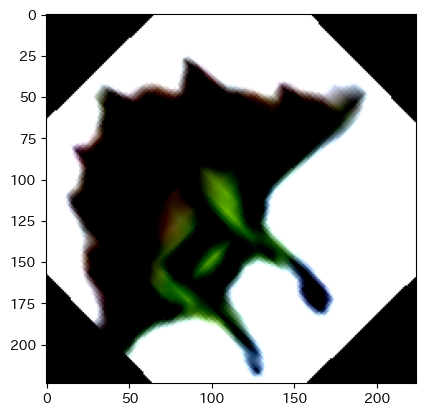

In [24]:
img_n, _ = cifar100_train[1]
print(img_n.shape)
plt.imshow(img_n.permute(1,2,0))
plt.show()

### パラメータの設定

In [ ]:
# 転移学習
model = models.resnet34(pretrained=True)

# mobilenetv2の最終層を１００分類モデル用に変換,dropoutを不活性化する
# model.classifier[0] = nn.Dropout(p=0, inplace=False)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features,100)
# resnet18の場合
model.fc = nn.Linear(in_features=1280, out_features=100)
print(model.fc)

# モデルのパラメータの更新を凍結する
params_to_update = []
update_param_names = ['fc.weight', 'fc.bias']
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
# 学習するパラメータを確認
print(params_to_update)

# パラメータの数の確認
numel_lists = [i.numel() for i in model.parameters()]
sum(numel_lists)

In [ ]:
# 学習率の設定
learning_rate = 1e-2
# パラメータの修正に確率的勾配降下方を利用
# momentumは過去に学習した勾配をどのくらい重視するか決めるもの。値が大きいほど重視する
optimizer = optim.SGD(params=params_to_update, lr = learning_rate, momentum=0.9) 
# 損失関数を定義
loss_fn = nn.CrossEntropyLoss()
# エポック数を設定
n_epochs = 10

### 訓練

In [ ]:
# resnet101を転移学習している。
model

In [ ]:
# 転移学習のチャンクを実行しなければファインチューニングとなる。
model,loss_train_lists, loss_val_lists,train_accuracies,val_accuracies = train_loop.fine_tuning(n_epochs = n_epochs,
                                            optimizer=optimizer,
                                            model = model,
                                            loss_fn = loss_fn,
                                            train = train_loader,
                                            val = val_loader
                                            )

### 結果表示

In [ ]:
title = 'ResNet34_finetuning'
plt.plot(train_accuracies,label = 'train')
plt.plot(val_accuracies, label ='val')
plt.title(f'{title}')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend()
plt.savefig(f'picture/accuracy_{title}')
plt.show()
# 損失
plt.plot(loss_train_lists,label = 'train')
plt.plot(loss_val_lists, label ='val')
plt.title(f'{title}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(f'picture/{title}.png')
plt.show()